# STAT 201 Project Proposal
### Group 16

## 2. Preliminary Results

We begin by loading the necessary R libraries for data wrangling and statistical inference.

In [95]:
library(tidyverse)
library(broom)
library(infer)
library(zoo)

Next, we read the data from CSV files downloaded from the Vancouver Police Department (https://geodash.vpd.ca/opendata/) for the years 2018-2022 in the neighbourhood West Point Grey. This data is combined into a single data frame (wpg) which is then cleaned by selecting only the columns of interest (crime type, year, and month), categorizing crime into two-year periods representing pre-covid (March 2018 - Feb 2020) and post-covid (March 2020 - Feb 2022).

In [2]:
west_point_grey_2018 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2018.csv", show_col_types = FALSE)
west_point_grey_2019 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2019.csv", show_col_types = FALSE)
west_point_grey_2020 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2020.csv", show_col_types = FALSE)
west_point_grey_2021 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2021.csv", show_col_types = FALSE)
west_point_grey_2022 <- read_csv("https://raw.githubusercontent.com/willis-cao/stat201-project-group16/main/crimedata_csv_West%20Point%20Grey_2022.csv", show_col_types = FALSE)

wpg <- rbind(west_point_grey_2018, 
             west_point_grey_2019,
             west_point_grey_2020,
             west_point_grey_2021,
             west_point_grey_2022) |>
    select(TYPE, YEAR, MONTH) |>
    filter((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | YEAR == 2020 | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) |>
    mutate(PERIOD = case_when(((YEAR == 2018 & MONTH > 2) | YEAR == 2019 | (YEAR == 2020 & MONTH < 3)) ~ 'pre',
                              ((YEAR == 2020 & MONTH > 2) | YEAR == 2021 | (YEAR == 2022 & MONTH < 3)) ~ 'post')) |>
    mutate(TYPE = as.factor(TYPE),
           PERIOD = as.factor(PERIOD))

head(wpg)

TYPE,YEAR,MONTH,PERIOD
<fct>,<dbl>,<dbl>,<fct>
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,5,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,11,pre
Break and Enter Commercial,2018,9,pre
Break and Enter Commercial,2018,12,pre


Breaking down the data month-by-month in the form of a barplot, we see that there is a spike in the number of break and enter crimes immediately following COVID restrictions (March 2020, represented by the vertical black line).

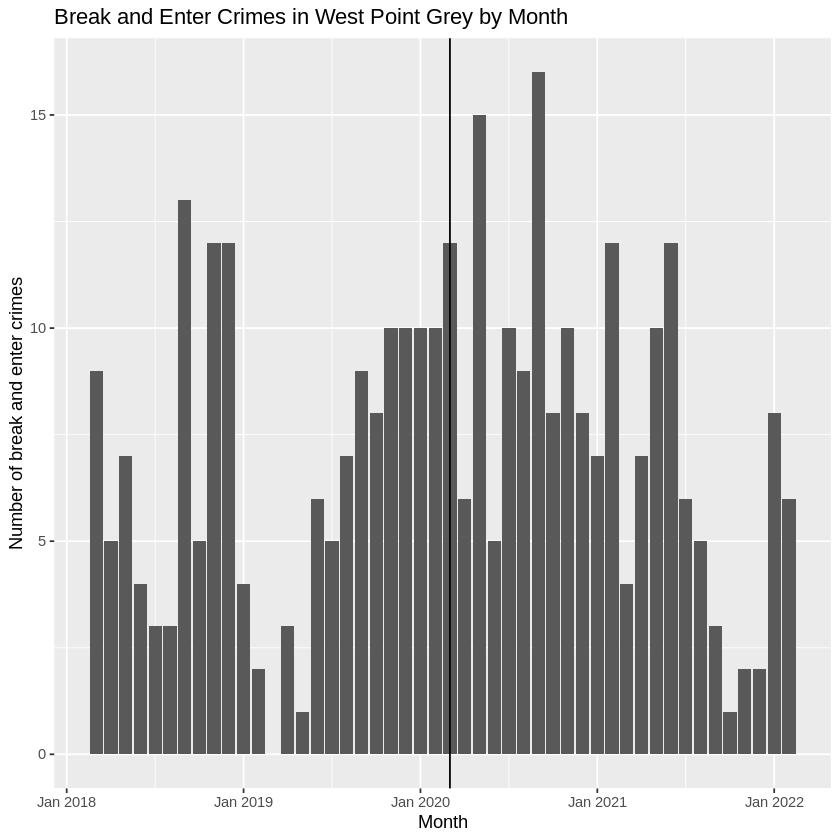

In [85]:
line_plot <- wpg |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    mutate(YEARMON = as.yearmon(paste(YEAR, MONTH), "%Y %m")) |>
    ggplot() +
    geom_bar(aes(x = YEARMON)) +
    geom_vline(xintercept = as.yearmon(paste(2020, 03), "%Y %m")) +
    labs(title = "Break and Enter Crimes in West Point Grey by Month",
         x = "Month", 
         y = "Number of break and enter crimes")

line_plot

Next, we calculate summary statistics for the proportion of break and enter crimes (out of all crimes) across both time periods.

In [32]:
summary_tibble <- wpg |>
    group_by(PERIOD) |>
    summarize(n_break = sum(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other"),
              n_total = n()) |>
    mutate(prop_break = n_break / n_total)

summary_tibble

PERIOD,n_break,n_total,prop_break
<fct>,<int>,<int>,<dbl>
post,184,780,0.2358974
pre,158,882,0.1791383


A visual representation of the data is below, in the form of a stacked barplot.

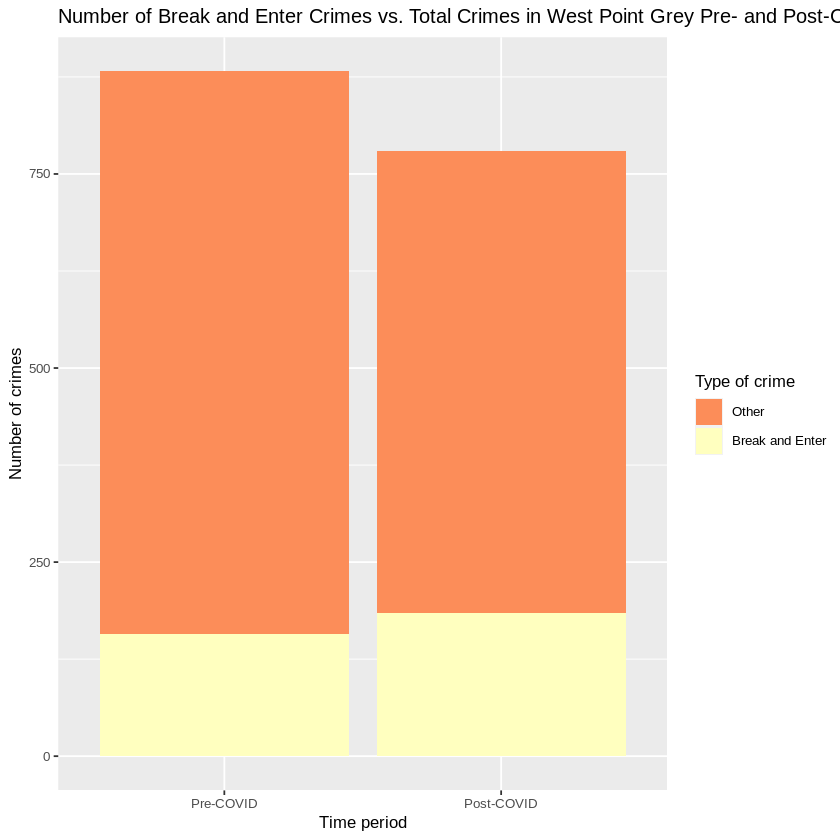

In [84]:
stacked_barplot <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    ggplot() +
    geom_bar(aes(x = factor(PERIOD, levels = c("pre", "post")), fill = factor(TYPE, levels = c("Other", "Break and Enter")))) +
    scale_x_discrete(labels = c("pre" = "Pre-COVID", "post" = "Post-COVID")) +
    labs(title = "Number of Break and Enter Crimes vs. Total Crimes in West Point Grey Pre- and Post-COVID", 
         x = "Time period", 
         y = "Number of crimes", 
         fill = "Type of crime") +
    theme(text = element_text(size = 10)) +
    scale_fill_brewer(palette = "Spectral")

stacked_barplot

We can observe from the summary table and the barplot that the total number of crimes decreased post-COVID, but the number of break and enter crimes increased. Is this difference significant?

### BELOW CODE IS FOR FINAL REPORT

Setting `type = "bootstrap"` in `generate()`.



lower_ci,upper_ci
<dbl>,<dbl>
0.02036205,0.09364916


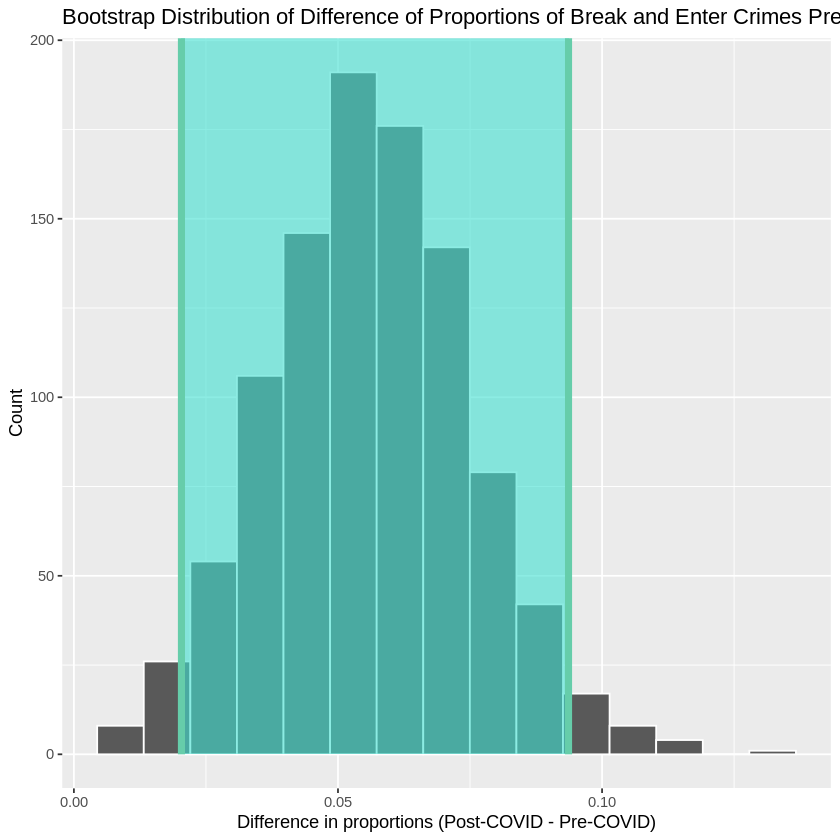

In [98]:
set.seed(2023)

bootstrap_reps <- 1000

diff_in_props_bootstrap <- wpg |>
    mutate(TYPE = case_when(((TYPE != "Break and Enter Commercial") & (TYPE != "Break and Enter Residential/Other")) ~ "Other",
                           ((TYPE == "Break and Enter Commercial") | (TYPE == "Break and Enter Residential/Other")) ~ "Break and Enter")) |>
    specify(TYPE ~ PERIOD, 
            success = "Break and Enter") |>
    generate(reps = bootstrap_reps) |>
    calculate(stat = "diff in props", order = c("post", "pre"))

diff_in_props_ci <- diff_in_props_bootstrap |>
    get_confidence_interval(level = 0.95, type = "percentile")

diff_in_props_ci

diff_in_props_bootstrap_dist <- diff_in_props_bootstrap |>
    visualize() +
    shade_confidence_interval(diff_in_props_ci) +
    labs(title = "Bootstrap Distribution of Difference of Proportions of Break and Enter Crimes Pre- and Post-COVID",
         x = "Difference in proportions (Post-COVID - Pre-COVID)",
         y = "Count")

diff_in_props_bootstrap_dist

In [64]:
z_test <- tidy(prop.test(
    x = n_break_col,
    n = n_total_col,
    correct = FALSE
    ))
z_test

ERROR: Error in tidy(prop.test(x = n_break_col, n = n_total_col, correct = FALSE)): could not find function "tidy"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



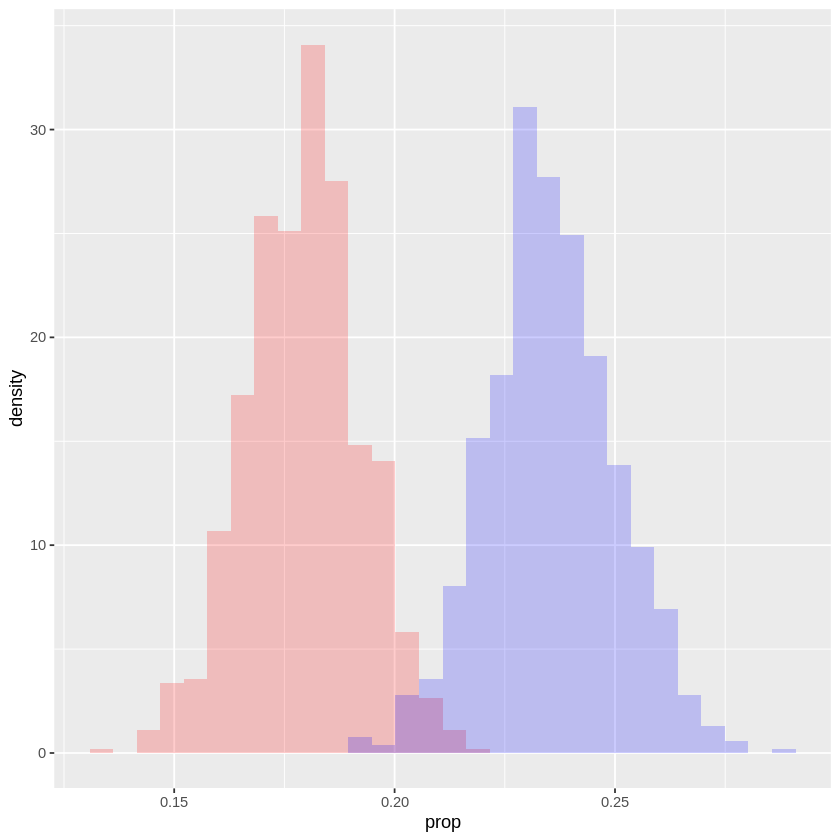

In [8]:
set.seed(2023)

bootstrap_reps = 1000

wpg_precovid_bootstrap <- wpg_precovid |>
    rep_sample_n(size = precovid_sample_size, reps = bootstrap_reps, replace = TRUE) |>
    count(TYPE) |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    group_by(replicate) |>
    summarize(count = sum(n)) |>
    mutate(prop = count / precovid_sample_size)

wpg_covid_bootstrap <- wpg_covid |>
    rep_sample_n(size = covid_sample_size, reps = bootstrap_reps, replace = TRUE) |>
    count(TYPE) |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    group_by(replicate) |>
    summarize(count = sum(n)) |>
    mutate(prop = count / covid_sample_size)

wpg_bootstrap_dist <- 
    ggplot() +
    geom_histogram(data = wpg_precovid_bootstrap, aes(prop, ..density..), fill = "red", alpha = 0.2) +
    geom_histogram(data = wpg_covid_bootstrap, aes(prop, ..density..), fill = "blue", alpha = 0.2)
    
wpg_bootstrap_dist